# Face Recognition #9

- We are using: Ubble dataset

We have used during the computation of the FAR and TAR only the encodings that have been previously generated in order to speed up the execution.
Each person is described by a vector that contains a certain number of  encodings generated from images among all the ones available for a certain person in a video.


##Basic import

In [0]:
import sys
import os
from google.colab import drive

drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/Colab Notebooks/PRIM/'  # your new root path

sys.path.append(os.path.join(root_path, 'notebooks')) # for importing from utils.py

!pip install face_recognition

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
     |████████████████████████████████| 100.2MB 31kB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566172 sha256=e4d14ef27022219639ed37f3934ccb2c664044f752d58361b4cd0ca2407e7537
  Stored in directory: /root/.cache/pip/wheels/d2/99/18/59c6c8f01e39810415c0e63f5bede7d83dfb0ffc039865465f
Successfully built face-recognition-models


In [0]:
import argparse
import pickle
import cv2
from imutils import paths
import face_recognition
import argparse
import pickle
import cv2
import os
import dlib
import matplotlib.pyplot as plt
import time
import pdb
import numpy as np
import random
import csv

print(dlib.DLIB_USE_CUDA)

True


In [0]:
#os.listdir(root_path + 'face_videos/face_videos')

## Creating new encodings & boxes

In [0]:
def createEncodings(dataset_vector, name , detection = 'cnn'):

    # grab the paths to the input images in our dataset
    print("[INFO] quantifying faces...")
    '''
    We're going to take all the images and create the encodings
    '''
    if len(dataset_vector )<= 0:
      print("AN ERROR OCCURRED FOR ",name)
      return

    images = dataset_vector#create the encodings for each frame in the video --> it will take a lot of time to do all the videos-> 5/6 hours

    # initialize the list of known encodings and known names
    knownEncodings = []
    knownNames = []

    ratios = []
    face_areas = []
    image_areas = []
        
    # loop over the image paths
    for image in images:
        # extract the person name from the image path
        #print("[INFO] processing image {}/{}".format(i + 1,len(imagePaths)))

        # load the input image and convert it from RGB (OpenCV ordering)
        # to dlib ordering (RGB)
        rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # detect the (x, y)-coordinates of the bounding boxes
        # corresponding to each face in the input image
        boxes = face_recognition.face_locations(rgb,model=detection)

        ######################### FACE RESOLUTION LOGIC
        for face_location in boxes:
            try:
                top, right, bottom, left = face_location
            except IndexError:
                top = right = bottom = left = 0

            area_face = (bottom-top) * (right-left)
            area_image = image.shape[0] * image.shape[1]
            ratio = area_face/area_image * 100
            #print('face:', area_face, 'image:', area_image, 'ratio:', ratio)

            ratios.append(ratio)
            face_areas.append(area_face)
            image_areas.append(area_image)
        #########################

        # compute the facial embedding for the face
        encodings = face_recognition.face_encodings(rgb, boxes)

        # loop over the encodings
        for encoding in encodings:
            # add each encoding + name to our set of known names and
            # encodings
            knownEncodings.append(encoding)
            knownNames.append(name)
            
    # dump the facial encodings + names to disk
    print("[INFO] serializing encodings..." + name)
    data = {"encodings": knownEncodings, "names": knownNames}
    file_name = root_path + "/encodings_face_videos_half/" + name + '.pkl'
    
    print(len(knownEncodings))

    f = open(file_name, "wb")
    f.write(pickle.dumps(data))
    f.close()


    #-------------------------------------------------------------------#
    boxfile = open(root_path + "/boxes/box_" + name + ".pkl", "wb")
    boxdata = {"ratio": ratios, "face": face_areas, "image": image_areas}
    boxfile.write(pickle.dumps(boxdata))
    boxfile.close()

In [0]:
def readFrames(path):
  
  video = cv2.VideoCapture(path)
  frames = []
  while(1):
      ret, frame = video.read()
      if ret == True:
        frames.append(frame)
      else:
          break
  return frames

In [0]:
base_video_path = root_path + 'face_videos/face_videos/'

In [0]:
'''
#encoding already generated not need of this codde anymore
videos = os.listdir(base_video_path)
global_start = time.time()
count = 0
for video_name in videos:
  start = time.time()
  #frames = readFrames(base_video_path + video_name)#remove the comment if you neeed to train new encodings
  frames = frames[0:int(len(frames)/2)]
  #createEncodings(frames,video_name)
  end = time.time()
  print('Time_enc:', end-start)
  print(count)
  count += 1

global_end = time.time()
print('Total time:', global_end-global_start)
'''

"\n#encoding already generated not need of this codde anymore\nvideos = os.listdir(base_video_path)\nglobal_start = time.time()\ncount = 0\nfor video_name in videos:\n  start = time.time()\n  #frames = readFrames(base_video_path + video_name)#remove the comment if you neeed to train new encodings\n  frames = frames[0:int(len(frames)/2)]\n  #createEncodings(frames,video_name)\n  end = time.time()\n  print('Time_enc:', end-start)\n  print(count)\n  count += 1\n\nglobal_end = time.time()\nprint('Total time:', global_end-global_start)\n"

## Code for test

In [0]:
def faceRecognitionENC(encodings_1, encodings_2, ratio, detection='cnn', show=False, tolerance = 0.6, min_area = 1):
    '''
    New version it only works with already made encodings
    encodings_1: single encoding of the person we want to recognize
    encodings_2: encodings of the person of which we know the name
    '''
    start = time.time()


    data = encodings_2

    dist = 1.0
    # initialize the list of names for each face detected
    names = []
    ######################### FACE RESOLUTION LOGIC
    discarded = "discarded"
    
    if (ratio < min_area):
        #discard the picture
        return discarded, dist
    #########################
    
    # attempt to match each encoding to our known encodings
    if global_number_enc > 0:
      data = data["encodings"][0:global_number_enc]
    else:
      data = data["encodings"]
    
    matches = face_recognition.compare_faces(data,encodings_1, tolerance= tolerance)
    
    name = "unknown"

    # check to see if we have found a match
    if True in matches:
      # Use the known face with the smallest distance to the new face 
      #this can help if in the video to recognize there is more than one person
      face_distances = face_recognition.face_distance(data, encodings_1)
      best_match_index = np.argmin(face_distances)

      if matches[best_match_index]:
          name = encodings_2["names"][best_match_index]
          dist = face_distances[best_match_index]

    # update the list of names
    try:
        name = name.split('/')[2]
    except:
        name = name
    names.append(name)
    
    return names, dist
    
def encodingsRead(path):
    ## PAY ATTENTION:: You need to create the encoding for you dataset using encode_face.py
    data = pickle.loads(open(path, "rb").read())
    return data

def boxesRead(path):
    try:
        data = pickle.loads(open(path, "rb").read())
    except FileNotFoundError:
        boxdata= np.ones(100)
        data = {"ratio": boxdata, "face": boxdata, "image": boxdata}
        print("---- Default box construction")
    return data
    

In [0]:
import json
#code to retrieve the real name starting from the rec name
with open( root_path +'labelled_videos.json') as json_file:
  data = json.load(json_file)

def readTrueName(rec_name):
  
  for real_name in data:
    if rec_name in data[real_name]:
      return real_name
  return "unknown"

Two types of early stopping:
* we reject the acces (return False) if after $minFrames$ the percentage of times the algorithm returns False is greater than $0.5$
* we grant the acces if the function **makeDecision** return true. This function starting from $minFrames/5$ compare the average distances (or the min) of the encodings till that moment and make a decison taking into account the number of frames alredy received. 

In [0]:
def makeDecision(distances,threshold,n_frames,min_frames_to_compare, mod = 'avg'):
  


  if len(distances)>0:
      if  mod == 'avg':
        min_d = np.mean(distances)
      else:
        if mod == 'min':
          min_d = np.amin(distances)
        else:
          print('Only avg or min supperted the default will be used')
          min_d = np.mean(distances)

      dists = np.linspace(0.2, 0.5,50)
      frames = np.linspace(int(min_frames_to_compare/5), min_frames_to_compare,50)
      '''
      HAND-MADE VARIANT
      if min_d <= 0.2:
        return True
      if min_d <= 0.25 and len(distances)>=(2/3)*min_frames_to_compare:
        return True
      if min_d <= 0.3 and len(distances)>=(3/4)*min_frames_to_compare:
        return True
      if min_d <= 0.35 and len(distances)>=(4/5)*min_frames_to_compare:
        return True
      if min_d <= 0.40 and len(distances)>=(5/6)*min_frames_to_compare:
        return True   
      if min_d <= 0.45 and len(distances)>=(6/7)*min_frames_to_compare:
        return True
      if min_d <= 0.50 and len(distances)>=(7/8)*min_frames_to_compare:
        return True
      '''
      for i in range(0,len(dists)):
        if min_d <= dists[i] and len(distances) >= frames[i]:
          return True                    
      
  if len(distances)/n_frames > threshold:
    return True
  
  return False

In [0]:
def faceRecOnENC(encoding_path, encodings, correct_person,test_person, detection='cnn',min_threshold = 0.85, 
                    min_frames_to_compare = 30 ,
                    show=False, tolerance = 0.6,
                    mod = 'avg',
                    min_area = 1):
    
    encodings_to_compare = encodingsRead(encoding_path)
    encodings_to_compare = encodings_to_compare["encodings"]#encoding of a different person
    
    
    
    box_path = root_path +"boxes/box_" + test_person + ".pkl"
    #pdb.set_trace()
    
    boxes_to_compare = boxesRead(box_path)
    ratio_to_compare = boxes_to_compare['ratio']
    
    test_person = readTrueName(test_person)

    start = time.time()

    analysed_frames = 0
    correct_frames = 0
    negative_frames = 0
    neutrum_frames = 0
    ignored_frames = 0
    global total_ignored
    total_ignored = 0
 #-----------------------#
    distances = []


    # grab the paths to the input images in our dataset
    #print("[INFO] Recognizing faces...")
    #total_frames = len(encodings_to_compare)
    #print("[INFO] elements:", total_frames)

    #we had some cases where no faces where recognised
    if len(encodings_to_compare) <= 0:
        return False, 0, 0, 0, 0


    # loop over the encodings
    frame_count = 0
    for enc in encodings_to_compare:
        # extract the person name from the image path
        #print("[INFO] processing image {}/{}".format(i + 1,len(imagePaths)))
    
      ratio = ratio_to_compare[frame_count]

      person, dist= faceRecognitionENC(enc, encodings, ratio,  detection='cnn', show=show, tolerance = 0.55, min_area = min_area)
    
      analysed_frames += 1
      frame_count += 1 
      if( person == "discarded"):
        # we are ignoring the frame
        analysed_frames -= 1
        ignored_frames += 1 
        #print("Discarded frame", frame_count, "ratio:", ratio)
        continue
      
      person = readTrueName(person[0])
      
      if(person == correct_person):#recognised
        distances.append(dist)
        

        if (correct_person == test_person): #correctly recognised
          correct_frames+=1 #true positive
        
        else:#wrongly recognised
          negative_frames += 1 #false positive

      else:#not recognized
        neutrum_frames += 1

      correct_rate = correct_frames/analysed_frames
      neutrum_rate = neutrum_frames/analysed_frames
      negative_rate = negative_frames/analysed_frames
      total_ignored = total_ignored + ignored_frames


      #-----------------------------------------------------------------------------------------------------------------#

      #TODO--> IMPROVE WITH DISTANCE CHECK
      #early stopping for negative result
      if (analysed_frames >= min_frames_to_compare ): # ex 30fps --> 45 frames = 1.5 second  ---early stopping
          
          if neutrum_frames/analysed_frames > 0.5:#early stopping for the negative 
            return False,correct_rate, neutrum_rate, negative_rate, analysed_frames

      #early stopping for positive result
      if (analysed_frames >= min_frames_to_compare/5): # ex 30fps --> 15 frames = 0.5 second  ---early stopping
          
          if(makeDecision(distances,min_threshold,analysed_frames,min_frames_to_compare, mod = mod)):
            return True,correct_rate, neutrum_rate, negative_rate, analysed_frames
      
      #--------------------------------------------------------------------------------------------------------------------#

    #for end --> if we don't have so many frames
          
    if (correct_frames + negative_frames)/analysed_frames > min_threshold:#ex 85% of the frames are recognised
      return True,correct_rate, neutrum_rate, negative_rate, analysed_frames
    else:
      return False,correct_rate, neutrum_rate, negative_rate, analysed_frames

The CrossedTest compare the encodings of one person with all the other encodings (same person or not)  in order to compute later Far and Tar.
Here each person is compared with all the other except that with himself.


In [0]:
def performCrossedTestENC(min_v=0, max_v=1000, threshold=0.85, log=False, tolerance = 0.6, mod = 'avg', min_area =1):
    print("-------------------------")
    print("TEST STARTED")
    print("-------------------------")
    start = time.time()

    count = 0
    enc_list = os.listdir(encodings_folder)
    test_dir = os.listdir(test_path)

    log_folder_base = 'logs_' + str(tolerance) + '_'+str(threshold) +'_'+str(global_number_enc)+'_'+str(global_min_frames)+'_'+str(mod)+'/'

    count_p = 0
    for encoding in enc_list:
        count = count + 1
        if(count < min_v):
            continue
        if(count > max_v):
            break

        n_test = 0
        n_correct = 0
        
        enc_name = encoding[0:len(encoding)-4]#removing '.pkl' from name
        encoding_path = encodings_folder + encoding
        
        start_2 = time.time()
        curr_encoding = encodingsRead(encoding_path)

        real_name_curr_encoding = readTrueName(enc_name)
        
        #there are some people that don't have a label
        if (real_name_curr_encoding == "unknown" or real_name_curr_encoding =="documents"):
          continue

        print('[ENC] Using encoding:', enc_name)
        count_p += 1
        if( log == True):
          #log_folder = log_folder_base + 'F/'
          try:
              os.mkdir(root_path + '/logs#9/' + log_folder_base)
              #os.mkdir(root_path + '/logs#9/' + log_folder)
          except FileExistsError:
              print('Already existing folder')

          logfile = open(root_path + '/logs#9/' + log_folder_base + "log_" + enc_name + ".txt", "w")

        
        for person in test_dir:
            
            if ( enc_name == person[0:len(person)-4]):#removing '.pkl' from name 
              continue

            test_enc = test_path + person            
            person = person[0:len(person)-4]
            
            #print('Testing on test encoding:', person)
            
            real_name_test_encoding = readTrueName(person)

            if (real_name_test_encoding == "unknown" or real_name_test_encoding =="documents"):
              continue
            
            #video = readFrames(base_video_path +  person)#we send also the video to simulate the real input data but we use the encodings previously generated in order to speed up the execution
            #pdb.set_trace()
            # test the encodings of testset               
            v, a, b, c, d = faceRecOnENC(test_enc, curr_encoding, real_name_curr_encoding, person, min_threshold=threshold, show=False, tolerance = tolerance, 
                                         min_frames_to_compare = global_min_frames,mod = mod, 
                                         min_area = min_area)
                                      
            
            if(log== True):
                line = person + " " + str(d) + " " + str(v) + " " + str(a) + " " + str(b) + " " + str(c) + "\n"
                logfile.write(line)
                #print(line)
            if( v == True):
                n_correct += 1

        if(log == True):
            logfile.close()
        
        end_2 = time.time()
        


        print("-------------------------")
        print('The comparison last:', end_2-start_2)
        print("-------------------------")
        if count %10 == 0:
          print('Percentage of people:', int(count_p*100/285),'%')
          print("-------------------------")
    
    end = time.time()
    print("-------------------------")
    print("TEST ENDED")
    print("-------------------------")
    print('This test last:', end-start)
    return

## Code for Statistics

###Pies

In [0]:
from sklearn.metrics import roc_curve, auc


from google.colab import files

def showStats(folder,tolerance, show = True):

  print("##############")
  print("TOLERANCE",tolerance)
  print("#############")


  FAR_path = folder

  files = os.listdir(FAR_path)


  values = [0.85]
  confirmed_rate = np.zeros(len(values))
  i = 0

  for thr in values:
      total_files = 0
      recognized = 0
      notdetected = 0
      wrong = 0
      wrong_confirmed = 0
      wrong_confirmed2 = 0
      wrong_confirmed3 = 0
      wrong_confirmed4 = 0

      global_pos_count = 0
      global_pos = 0
      global_neg_count = 0
      global_neg = 0

      ####
      n_frames = 0
      one_wrong_rec = 0
      persons = 0
      for f in files:
          if( f.startswith('log') == True):
              filev = open(FAR_path + f, "r")
              vector = f.split('_')[1].split(".")[0]
              correct_person = readTrueName(vector + '.webm')
              lines = filev.readlines()
              persons += 1
              for line in lines: 
                  
                  name = line.split(' ')[0]
                  total_files += 1

                  n_frames += int(line.split(' ')[1])
                  rec_flag = line.split(' ')[2]

                  #pdb.set_trace()
                  rec_percentage = float(line.split(' ')[3])
                  notdec_percentage = float(line.split(' ')[4])
                  notrec_percentage = float(line.split(' ')[5])

                  if(readTrueName(name) == correct_person):#same person
                      
                      if rec_flag == 'True':#acces granted correctly
                        global_pos +=1
                      
                      global_pos_count+=1
                  
                  else:#non sono la stessa persona
                      if rec_flag == 'True':#wrong acces granted 
                        global_neg +=1
                      
                      global_neg_count+=1



                  recognized = recognized + rec_percentage
                  notdetected = notdetected + notdec_percentage
                  wrong = wrong + notrec_percentage

                  if(notrec_percentage > thr):
                      wrong_confirmed = wrong_confirmed + 1
      
      if(total_files == 0):
          total_files = 1
      confirmed_rate[i] = wrong_confirmed / total_files
      wrong_confirmed = 0
      i = i +1

  ## equal for each iteration
  positive = recognized / total_files 
  undetected = notdetected / total_files
  negative = wrong / total_files

  wrong_rec_on_persons = one_wrong_rec / (persons-1)

  #----------------------------------------------------------------------------#
  
  ## WRONG ONES WHERE ASSIGNED TO THE PERSON EVEN IF HE WASN'T
  '''
  if show:
    labels = ['Correct', 'NotRecognized', 'Wrong']
    colors = ['Blue', 'Yellow', 'Orange']
    sizes1 = [positive, undetected, negative]


    plt.pie(sizes1, labels=labels, shadow=True, startangle=90, colors=colors)
    plt.title('Recognition average over all the images')
    plt.legend()
    plt.show()
    print('Percentage of overall images that were correctly not recognized:', undetected)
    print('\n\n')
  '''
  #--------------------------------------------------------------------------------------------#
  
  cfr = global_neg/global_neg_count
  
  if show:
    labels = ['Wrongly Confirmed', 'Correclty Not Confirmed']
    colors = ['Red','Green']
    sizes1 = [cfr, (1 - cfr)]



    plt.pie(sizes1, labels=labels, shadow=True, startangle=90, colors=colors)
    plt.title('Confirmation percentage using our algorithm metrics')
    plt.show()
    print('Percentage of TRR ' 'is', 1-cfr)
    print('Percentage of FAR ' 'is', cfr)
    print('\n\n')
  
  TRR = 1-cfr
  FAR = cfr
  #--------------------------------------------------------------------------------------------------------------------------#

  cfr = global_pos/global_pos_count
  if show:
    labels = ['Correctly Confirmed', 'Wrongly Not Confirmed']
    colors = ['Green', 'Red']
    sizes1 = [cfr, (1 - cfr)]


    plt.pie(sizes1, labels=labels, shadow=True, startangle=90, colors=colors)
    plt.title('Confirmation percentage using our algorithm metrics')
    plt.show()
    print('Percentage of TAR ' 'is', cfr)
    print('Percentage of FRR ' 'is', 1-cfr)

  TAR = cfr
  FRR = 1-cfr
  #--------------------------------------------------------------------------------------------------------------------------#
  #mean FRAMES

  print('Mean frames analysed',n_frames/(persons*persons))
  return TRR,FAR,TAR,FRR

###ROC&stat

In [0]:
def showStatsROC(log_folder):
  files = os.listdir(log_folder)


  values = [0.20, 0.40, 0.45, 0.55, 0.60, 0.65, 0.75, 0.80, 0.85, 0.90, 0.95, 0.99, 0.9999]
  confirmed_rate = np.zeros(len(values))
  confirmed_rateT = np.zeros(len(values))
  i = 0

  for thr in values:
      total_files = 0    
      total_files_t = 0
      recognized = 0
      notdetected = 0
      wrong = 0
      confirmed = 0
      wrong_confirmed = 0
      wrong_confirmed2 = 0
      wrong_confirmed3 = 0
      wrong_confirmed4 = 0

      ####
      one_wrong_rec = 0
      persons = 0
      for f in files:
          if( f.startswith('log') == True):
              filev = open(log_folder + f, "r")
              vector = f.split('_')[1].split(".")[0]
              correct_person = readTrueName(vector + ".webm")
              lines = filev.readlines()
              persons += 1
              for line in lines: 
                  #we don't want to make statistics on the same person
                  name = line.split(' ')[0]

                  rec_flag = line.split(' ')[2]
                  rec_percentage = float(line.split(' ')[3])
                  notdec_percentage = float(line.split(' ')[4])
                  notrec_percentage = float(line.split(' ')[5])

                  if(readTrueName(name) == correct_person):
                      if(rec_percentage > thr):
                          confirmed = confirmed + 1
                      #print('hello')
                      total_files_t +=1
                  else:
                    total_files += 1


                  recognized = recognized + rec_percentage
                  notdetected = notdetected + notdec_percentage
                  wrong = wrong + notrec_percentage

                  if(notrec_percentage > thr):
                      wrong_confirmed = wrong_confirmed + 1
      
      if(total_files == 0 or total_files_t ==0):
          total_files = 1
          total_files_t = 1
      confirmed_rate[i] = wrong_confirmed / total_files
      confirmed_rateT[i] = confirmed / total_files_t
      wrong_confirmed = 0
      i = i +1

  ## equal for each iteration
  positive = recognized / total_files 
  undetected = notdetected / total_files
  negative = wrong / total_files

  wrong_rec_on_persons = one_wrong_rec / (persons-1)

  from sklearn.metrics import roc_curve, auc
  print("Tolerance: 0.45")
  fpr = confirmed_rate
  tpr = confirmed_rateT
  exampleX = [0.0, 0.0000001, 0.2, 0.8, 1.0]
  exampleY = [0.0, 1.0, 1.0, 1.0, 1.0]
  limitx = np.max(fpr)

  plt.figure()
  lw = 2
  plt.plot(exampleX, exampleY, color='green', linestyle='-', label='Ideal ROC')
  plt.scatter(fpr, tpr, color='darkorange',lw=lw, label='ROC curve')
  plt.scatter(fpr[1], tpr[1], color='red',lw=lw, label='thr: 0.4')
  plt.scatter(fpr[2], tpr[2], color='blue',lw=lw, label='thr: 0.45')
  plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', label='Random case')
  plt.xlim([-0.01, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC curve')
  plt.legend(loc="lower right")
  plt.show()

  plt.figure()
  lw = 2
  plt.plot(exampleX, exampleY, color='green', linestyle='-', label='Ideal ROC')
  plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve')
  plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', label='Random case')
  plt.xlim([-0.001, limitx+0.02])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Zooming in the ROC curve')
  plt.legend(loc="lower right")
  plt.show()

  print("Threshold:", values[1], "TAR:", tpr[1], "FAR", fpr[1])

## Run Experiments
We are going now to compare each person with all the other videos so both himselfand different one.
At the end we use the log to compute Tar,Trr,Far and Frr and Roc

In [0]:
encodings_folder = root_path + "/encodings_face_videos_half/"
test_path = encodings_folder #same we use only encodings

In [0]:
n_enc = [50]#encodig of the person on the server
n_f = [30]# 1s,2s,3s,
mods = ['avg','min']
for e in n_enc:
  for fm in n_f:
    for mod in mods:
      global_number_enc = e #number of encoding taken for each known person
      global_min_frames = fm

      performCrossedTestENC(min_v=0, max_v=500 ,tolerance = 0.45,log= True, threshold=0.4, mod = mod, min_area= -50)

## Show results

##############
ENCODINGS 50
FRAMES 90
MOD avg
#############
Tolerance: 0.45


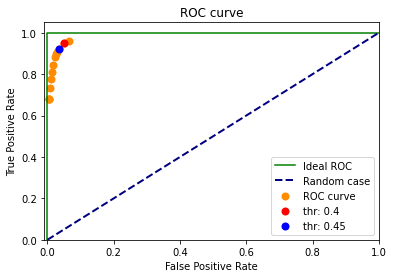

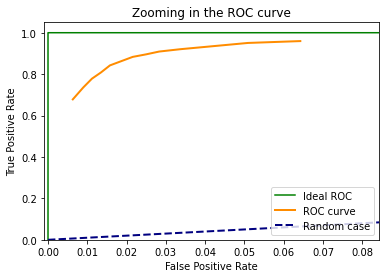

Threshold: 0.4 TAR: 0.950594353640416 FAR 0.0508891523414345
##############
ENCODINGS 50
FRAMES 90
MOD min
#############
Tolerance: 0.45


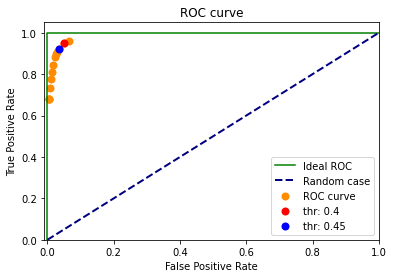

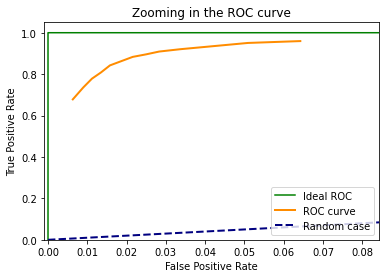

Threshold: 0.4 TAR: 0.950594353640416 FAR 0.0508891523414345
##############
ENCODINGS 50
FRAMES 120
MOD avg
#############
Tolerance: 0.45


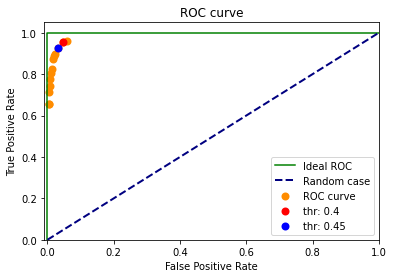

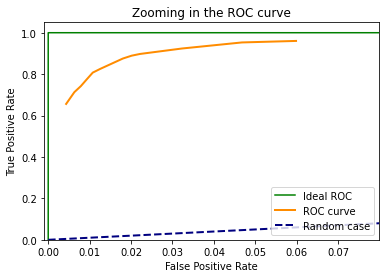

Threshold: 0.4 TAR: 0.9530460624071322 FAR 0.04678423236514523
##############
ENCODINGS 50
FRAMES 120
MOD min
#############
Tolerance: 0.45


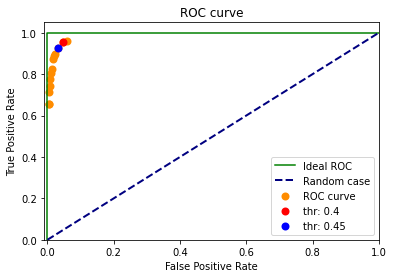

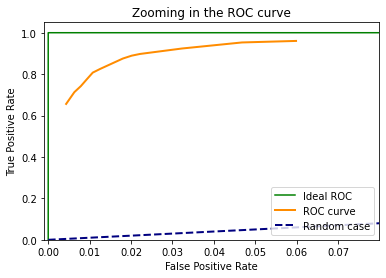

Threshold: 0.4 TAR: 0.9529717682020802 FAR 0.04678423236514523
##############
ENCODINGS 50
FRAMES 60
MOD avg
#############
Tolerance: 0.45


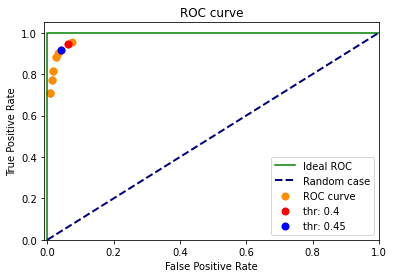

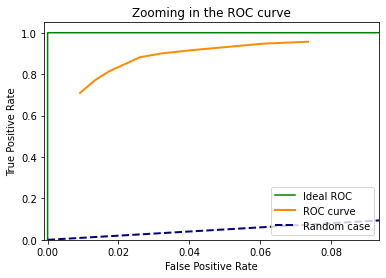

Threshold: 0.4 TAR: 0.9471025260029717 FAR 0.06084765856550089
##############
ENCODINGS 50
FRAMES 60
MOD min
#############
Tolerance: 0.45


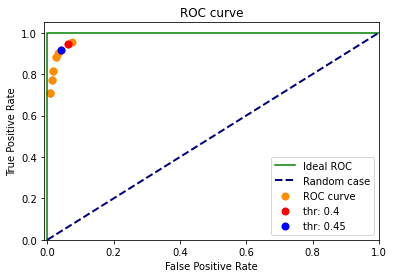

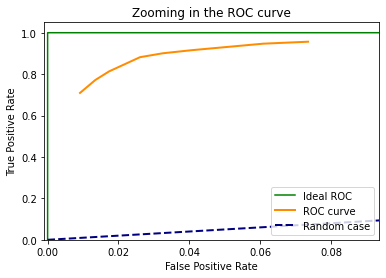

Threshold: 0.4 TAR: 0.9470282317979197 FAR 0.06084765856550089
##############
ENCODINGS 50
FRAMES 30
MOD avg
#############
Tolerance: 0.45


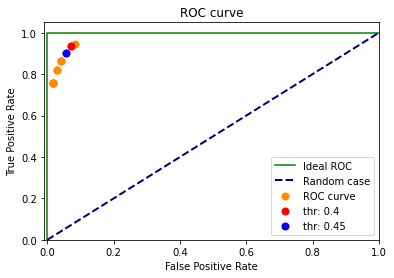

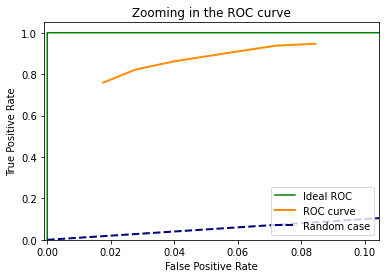

Threshold: 0.4 TAR: 0.937741456166419 FAR 0.07218435091879075
##############
ENCODINGS 50
FRAMES 30
MOD min
#############
Tolerance: 0.45


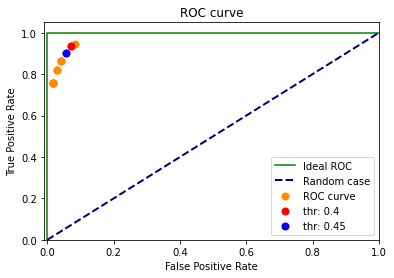

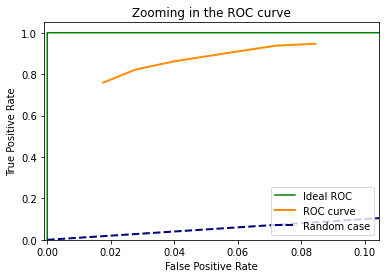

Threshold: 0.4 TAR: 0.937741456166419 FAR 0.07218435091879075


In [0]:
base_log = root_path +"logs#9/"
dirs = os.listdir(base_log)
for d in dirs:
    folder = base_log + d +'/'
    e = d.split('_')[3]
    f = d.split('_')[4]
    t = d.split('_')[1]
    m = d.split('_')[5]
    if e == '-1':
      e = 'All'
    print("##############")
    print("ENCODINGS",e)
    print("FRAMES",f)
    print("MOD",m)
    print("#############")
    #_,_,_,_ = showStats(folder,d)
    showStatsROC(folder)
